In [1]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from statsmodels.graphics.tsaplots import plot_acf


In [2]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt

In [3]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.23.5
5.7.2
0.15.1


## データの準備など

In [4]:
# データ用意
parray2 = pd.read_csv(f"../data/4-3-1-fish-num-4.csv")
df2 = pd.DataFrame(parray2)
print(df2.shape)
display(df2.head())

(94, 3)


,fish_num,temperature,human
0,2,12.7,A
1,6,13.7,B
2,9,15.7,C
3,5,19.1,D
4,11,12.0,E


## ランダム係数モデル

### 可視化

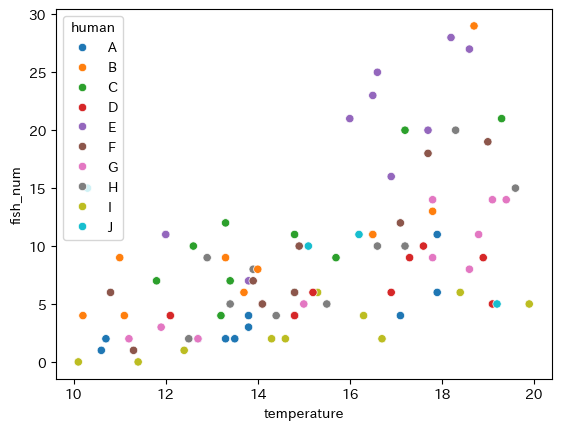

In [6]:
# データの可視化(天気ごと)
fig, ax = plt.subplots()
ax = sns.scatterplot(x = parray2["temperature"], y = parray2["fish_num"],
                     hue = parray2["human"])

In [8]:
# Jのデータが少ない
df2["human"].value_counts()

human
A    10
B    10
C    10
D    10
E    10
F    10
G    10
H    10
I    10
J     4
Name: count, dtype: int64

### ベイズ推論

#### 交互作用項でのモデリング

In [17]:
# データの準備
y = parray2["fish_num"].values
human_df = pd.get_dummies(df2["human"], dtype=int, drop_first=True)
